# Business objectives
Predict song hits 

## Data
[Spotify song's data](https://www.kaggle.com/edalrami/19000-spotify-songs)  
[Song's lyrics](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics)  
[fasttext embs](https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip)

## Data Mining goals
roc_auc > 0.7 [The traditional academic point system](http://gim.unmc.edu/dxtests/roc3.htm)

# Plan
<input type="checkbox"> load and prepare song and lyrics data
<br><input type="checkbox"> eda song's data
<br><input type="checkbox"> eda song's lyrics
<br><input type="checkbox"> modelling
<br><input type="checkbox"> evaluating the results

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import io
import re
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, RidgeCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import roc_auc_score

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import seaborn as sns; sns.set_style("whitegrid")
from matplotlib import rcParams
from matplotlib import pyplot as plt

init_notebook_mode(connected=True)
np.set_printoptions(suppress=True)

In [2]:
sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
PATH_SPOTIFY_SONG_DATA = "input/spotify_song_data.csv"
PATH_SPOTIFY_SONG_INFO = "input/spotify_song_info.csv"
PATH_LYRICS = "input/lyrics.csv"
PATH_WORD_EMBS = "input/wiki-news-300d-1M.vec"

# load song's data

In [4]:
df_data=pd.read_csv(PATH_SPOTIFY_SONG_DATA)
df_info=pd.read_csv(PATH_SPOTIFY_SONG_INFO)
df = df_data.merge(df_info[['artist_name']], left_index=True, right_index=True)
df = df.drop_duplicates().reset_index(drop=True)
del df_info, df_data 
df = df.groupby(['artist_name', 'song_name']).first().reset_index()
df['song'] = df['song_name'].apply(lambda x: '-'.join(x.lower().split()))
df['song'] = df['song'].apply(lambda x: re.sub(r'\([^)]*\)', '', x).strip())

df['artist'] = df['artist_name'].apply(lambda x: '-'.join(x.lower().split()))

# load song's lyrics

In [5]:
df_lyrics = pd.read_csv(PATH_LYRICS, index_col=0)
df_lyrics['lyrics'] = df_lyrics['lyrics'].str.lower()
lyrics_instr = ['instrumental',
'[instrumental]',
'(instrumental)',
'( instrumental )',
'instru',
'- instrumental -',
'[bonus track]',
'we are not in a position to display these lyrics due to licensing restrictions. sorry for the inconvinience.']


df_lyrics = df_lyrics[~df_lyrics['lyrics'].isin(lyrics_instr)].dropna().reset_index(drop=True)
df_lyrics['composition'] = df_lyrics['artist'].apply(lambda x: ' '.join(x.split('-')).title()) + ' - ' + df_lyrics['song'].apply(lambda x: ' '.join(x.split('-')).capitalize())
df_lyrics = df_lyrics.dropna().reset_index(drop=True)

In [6]:
df = df.merge(df_lyrics, on=['artist','song'])
del df_lyrics

In [7]:
window_length = 200
vec_len = 300

def normalize(text):
    return re.sub(r"[^a-z0-9]+", " ", text.lower())

def text_to_vector(dct_text_vec, text):
    """
    Given a string, normalizes it, then splits it into words and finally converts
    it to a sequence of word vectors.
    """
    text = normalize(text)
    words = text.split()
    window = words[-window_length:]
    
    x = np.zeros((window_length, vec_len))
    for i, word in enumerate(window):
        if word in dct_text_vec:
            x[i, :] = np.array(dct_fasttext[word]).astype('float32')
    return x.mean(axis=0)


def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

dct_fasttext = load_vectors(PATH_WORD_EMBS)

# EDA

* **The popularity** of a song is a metric of how often the song has been streamed on Spotify，but with more recent streams weighted more heavily.
* **Acousticness** describes whether the song uses primarily acoustic instruments or electronic/electric instruments. A value of 1.0 indicates that a song is purely acoustic. From hist - ratio 2:1
* **Danceability** describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythmic stability, beat strength, and overall regularity, with a value of 1.0 indicating high danceability.
* **Duration (ms)** simply indicates the length of the song. Close to normal distibution.
* **Energy** is different from danceability in that it is a perceptual measure of intensity and activity. Energetic tracks feel dense, fast, loud, and noisy. For example, death metal would have a high energy value while a Bach prelude would have a low one. Songs skewed towards having higher energy.
* **Instrumentalness** describes the extent to which the singer is not the primary performer of the song.
* **Key** represents the key signature the track is in. Integers map to pitches using standard pitch class notation where 0 = C, 1 = C#/Db, 2 = D, etc.
* **Liveness** detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the song was performed and recorded live. It appears that most songs are studio-recorded.
* The overall **loudness** of a recording is measured in decibels (dB). Loudness values are averaged across the entire song and typically range between -60dB and 0dB.
* **Mode** indicates whether a song is in primarily a major key or a minor key. 
* **Speechiness** detects the presence of spoken words in a recording. The more exclusively speech-like the recording (ex. talk shows, audio books, etc.), the closer the speechiness is to 1.0. A significant number have non-zero speechiness, most likely rap songs.
* A song's **tempo** is its speed, or the number of beats per minute (BPM). Tempo roughly appears to be normally distributed around 120BPM.
* **The time signature** is a notational convention to specify how many beats are in each bar of music. 
* **Valence** describes the musical positiveness conveyed by the song. In other words, songs with high valence sound more happy/positive/cheerful while songs with low valance sound more negative/depressed/angry. 


### Plot data distribution

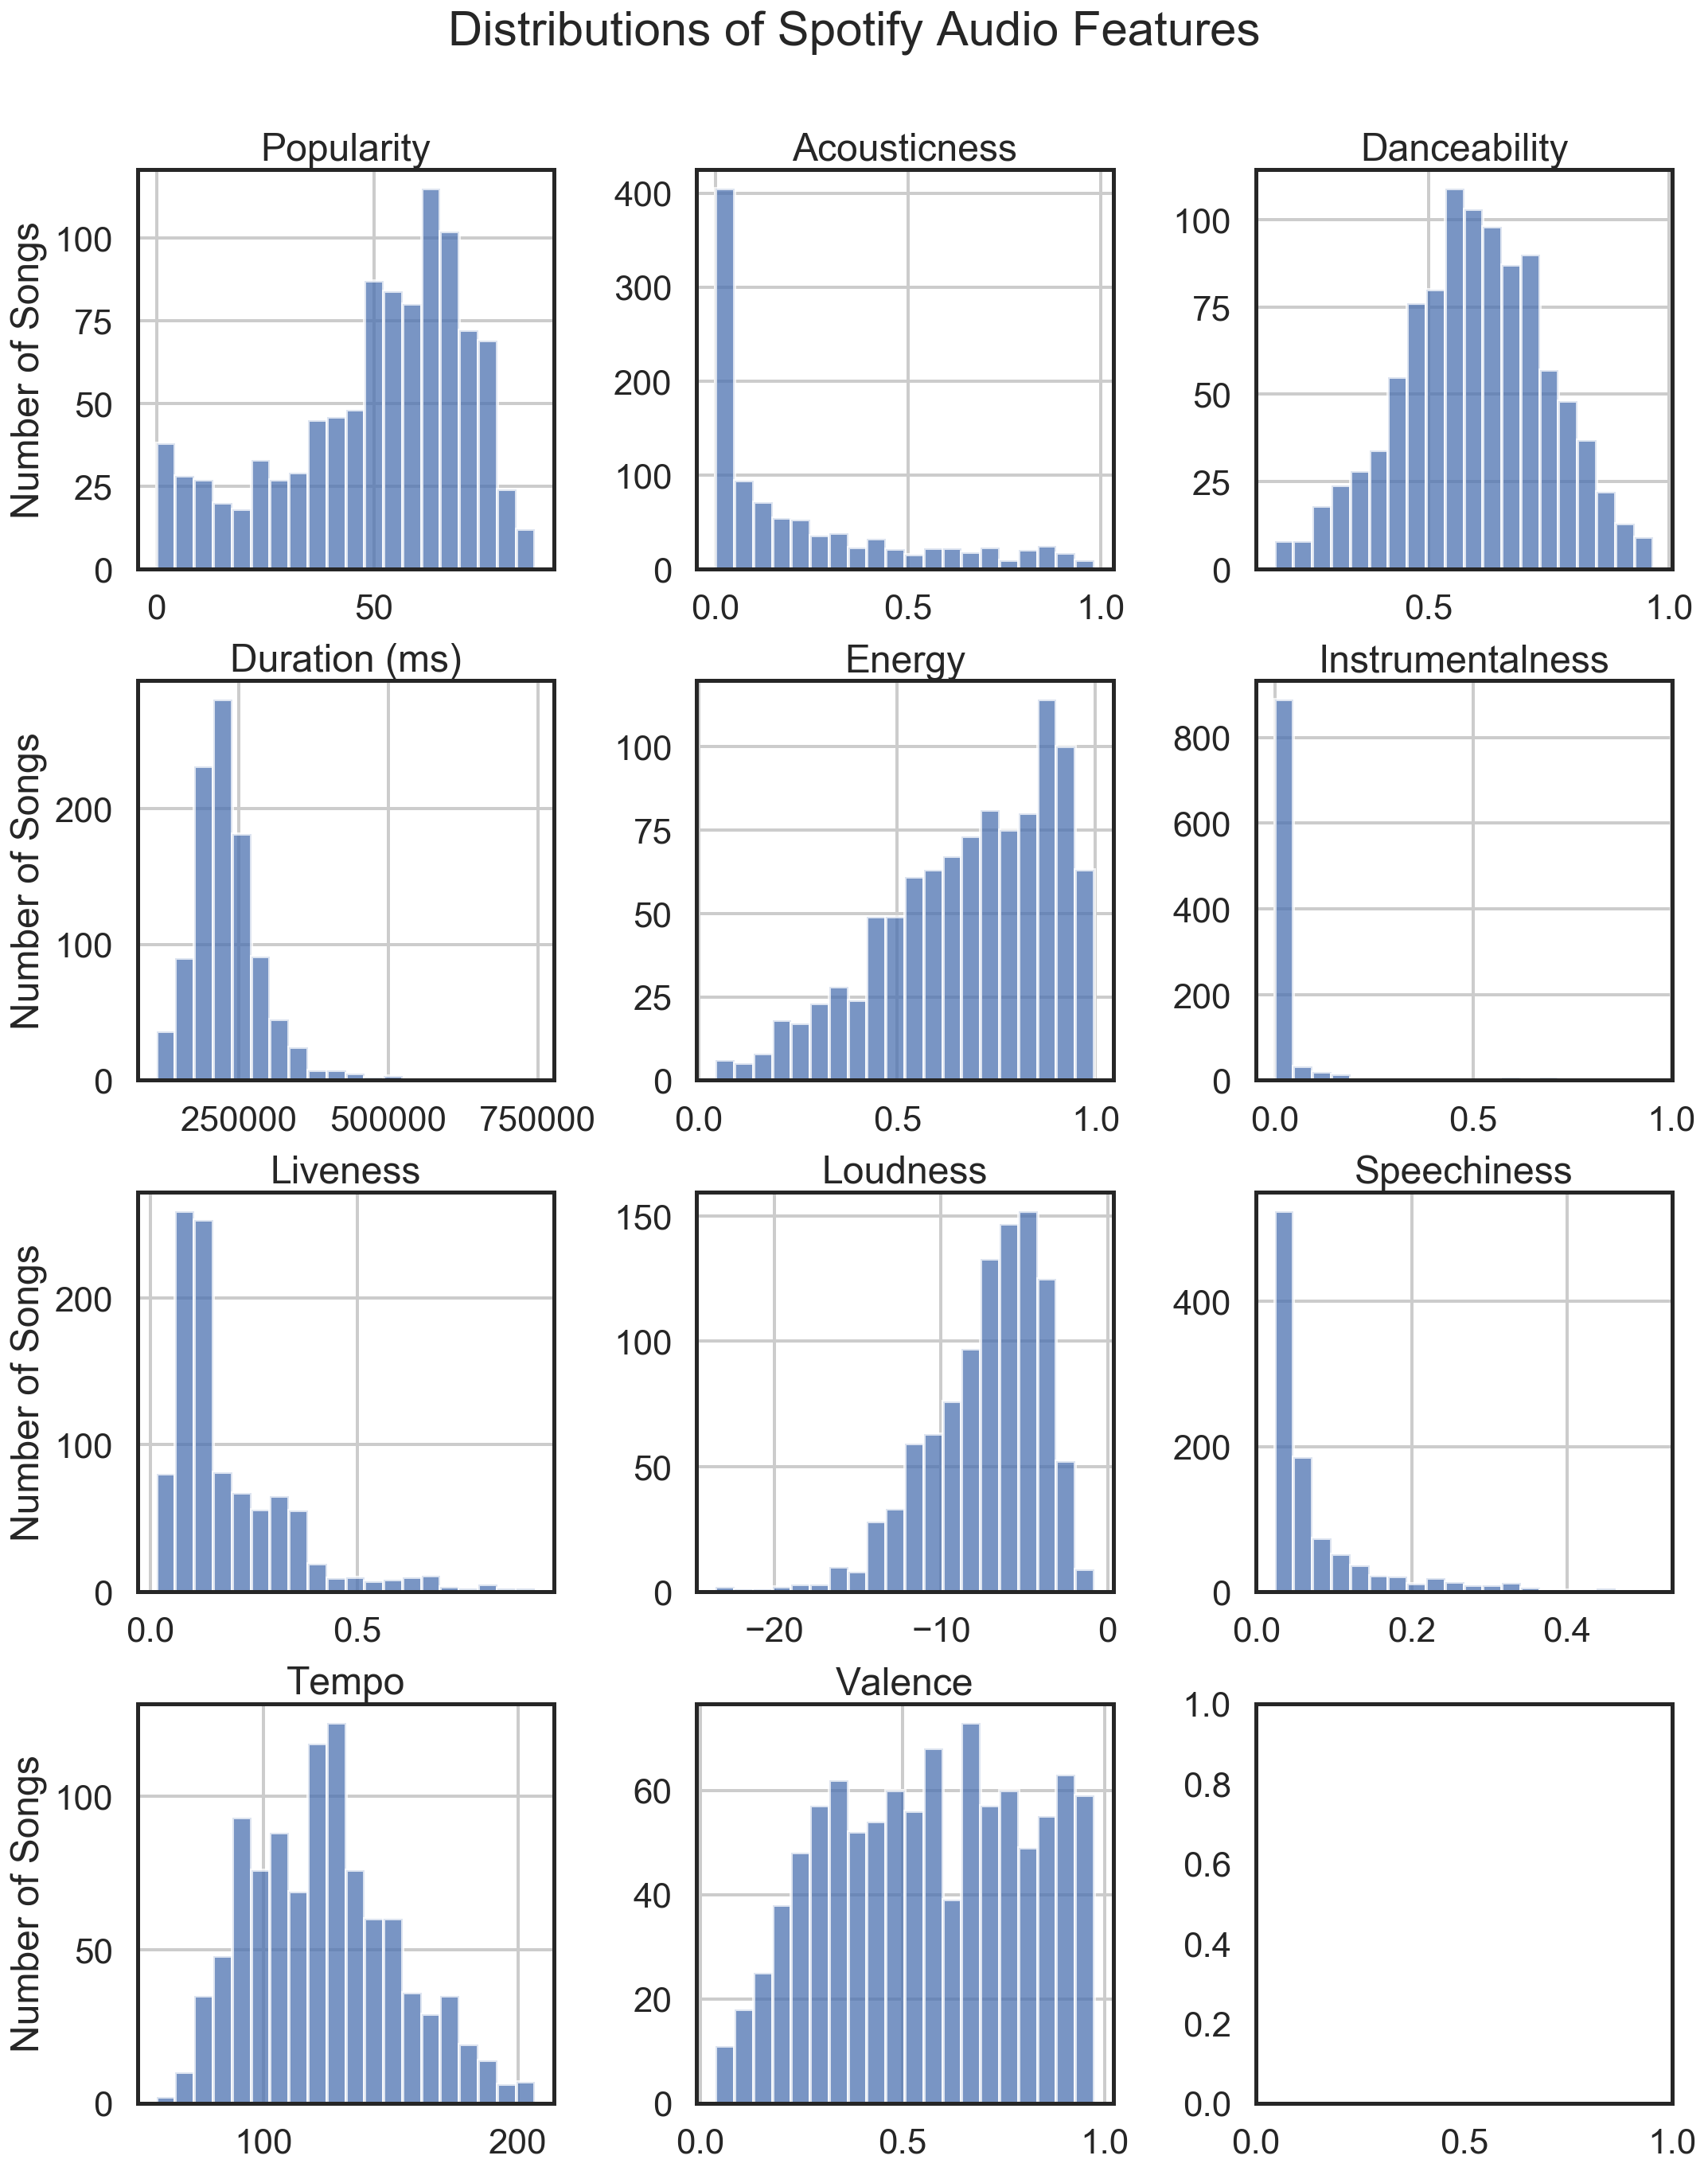

In [8]:
col_hist = ['song_popularity', 'acousticness', 'danceability', 'song_duration_ms', 
            'energy', 'instrumentalness', 'liveness', 'loudness', 
            'speechiness',  'tempo',  'audio_valence']

titles = ['Popularity', 'Acousticness', 'Danceability', 'Duration (ms)', 
          'Energy', 'Instrumentalness',  'Liveness', 'Loudness', 
           'Speechiness', 'Tempo', 'Valence']

fig, ax = plt.subplots(4, 3)
n_ax_row = 3
for i, col in enumerate(col_hist):
    curr_ax = ax[i // n_ax_row, i % n_ax_row]
    df[col].hist(figsize=(15,18), bins=20, alpha=0.75, ax=curr_ax)
    curr_ax.set_title(titles[i])
    if i % n_ax_row == 0:
        curr_ax.set_ylabel('Number of Songs')
plt.suptitle('Distributions of Spotify Audio Features', fontsize=30, y=1.05)
plt.tight_layout()

In [9]:
col_cat=["key","audio_mode","time_signature"]

col_quant=["song_duration_ms",
"acousticness",
"danceability",
"energy",
"instrumentalness",
"liveness",
"loudness",
"speechiness",
"tempo",
"audio_valence"]

df['is_hit'] = (df['song_popularity']>=70).astype(int)

### Plot influenced  lyrics words for each feature

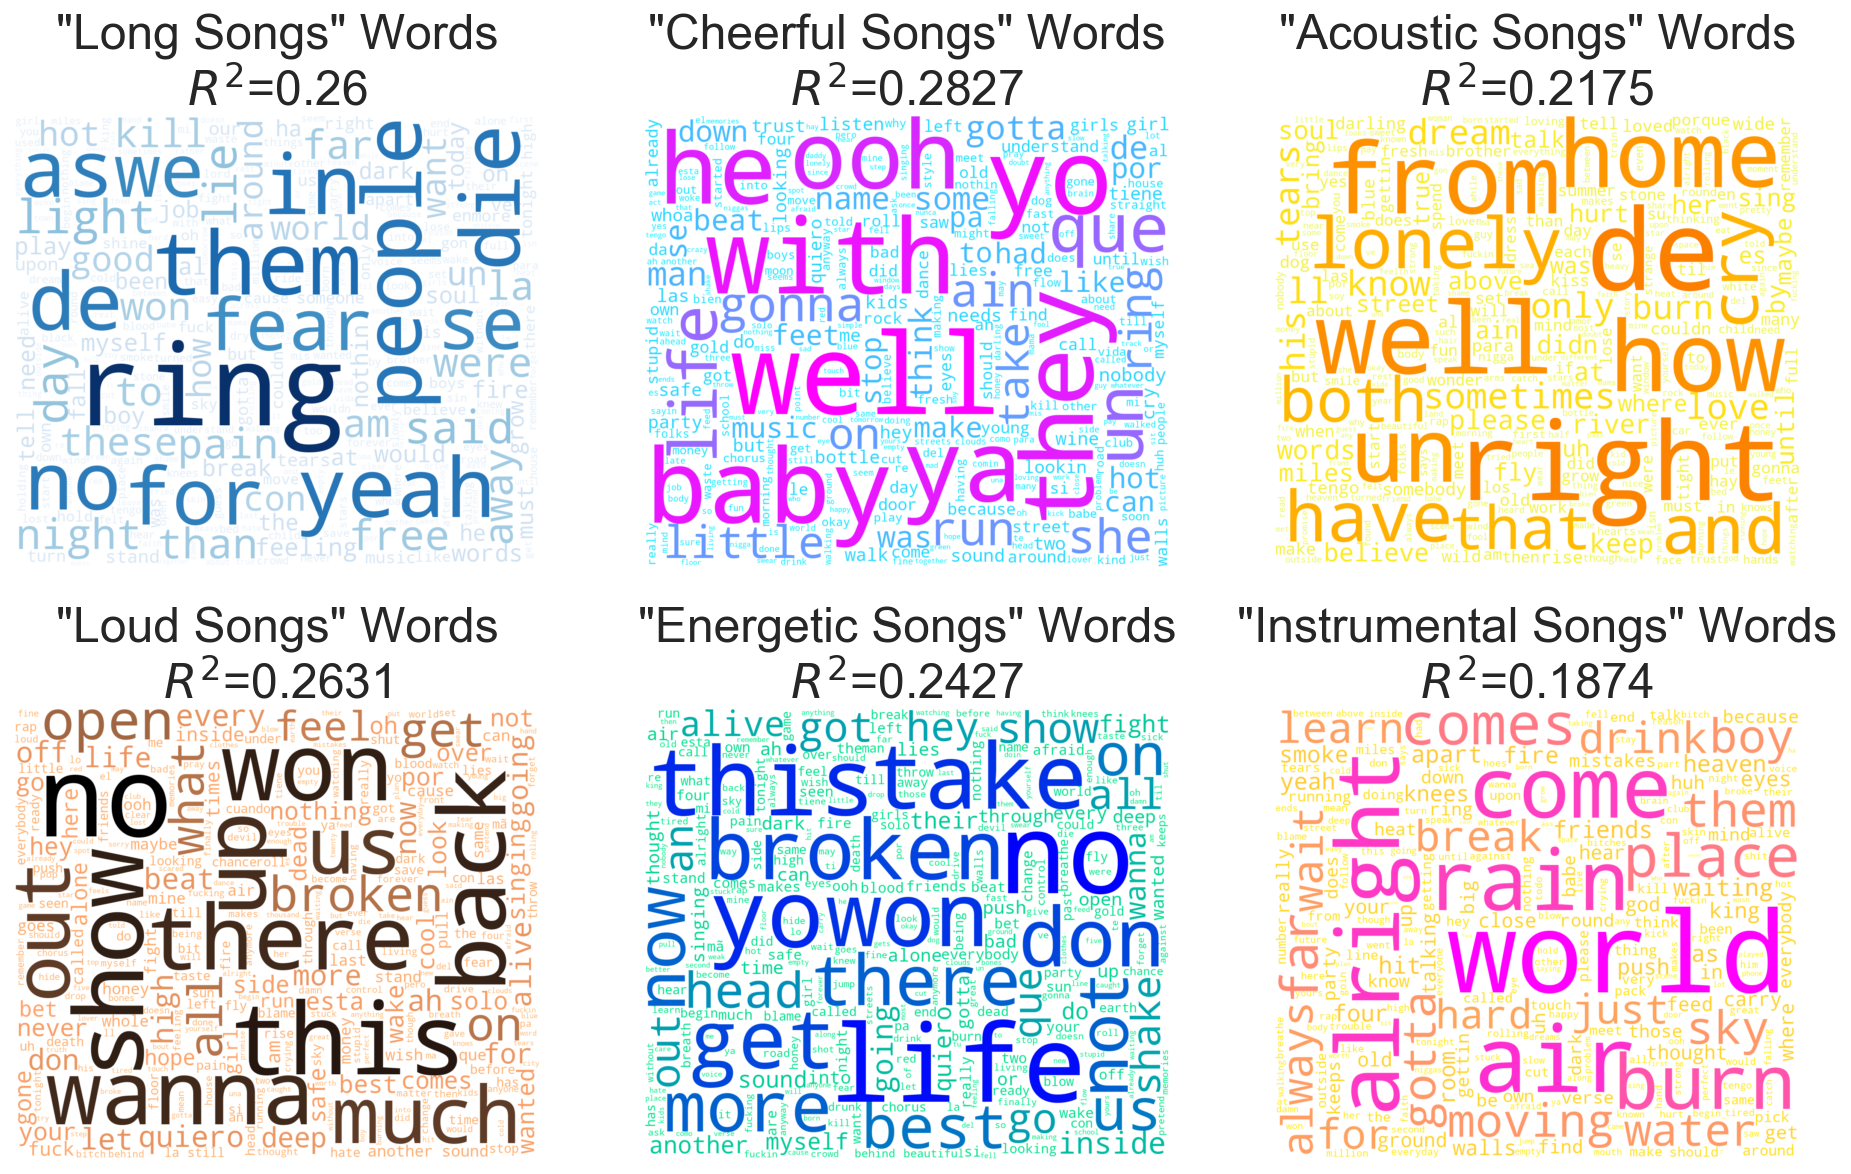

In [10]:
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)
fig, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()

audio_features = ['song_duration_ms', 'audio_valence', 'acousticness','loudness', 'energy', "instrumentalness",]
titles = [ '"long songs" words', '"cheerful songs" words',
          '"acoustic songs" words', '"loud songs" words', '"energetic songs" words' , '"instrumental songs" words']
cmaps = ['Blues', 'cool', 'Wistia', 'copper_r', 'winter_r', 'spring_r']

count = CountVectorizer(min_df=20, max_df=1000)
X_vect = count.fit_transform(df['lyrics'])
for i, feature in enumerate(audio_features):
    ridge = RidgeCV(alphas=[1, 10, 30, 1e2, 3e2, 1e3, 2e3, 3e3, 4e3, 1e5, 3e5])
    ridge.fit(X_vect, df[feature])
    score = ridge.score(X_vect, df[feature])
    coefs = ridge.coef_
    coefs = coefs.squeeze()
    vocab = count.get_feature_names()

    color_func = colormap_size_func(cmaps[i], 300)
    dictionary = dict(zip(vocab, coefs))
    wordcloud = WordCloud(background_color='white', height=1200,
                          min_font_size=5, width=1400, color_func=color_func,
                          max_words=300, relative_scaling=0.5,
                          max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title='{}\n$R^2$={:.4}'.format(titles[i], score).title())


### Plot correlation matrix

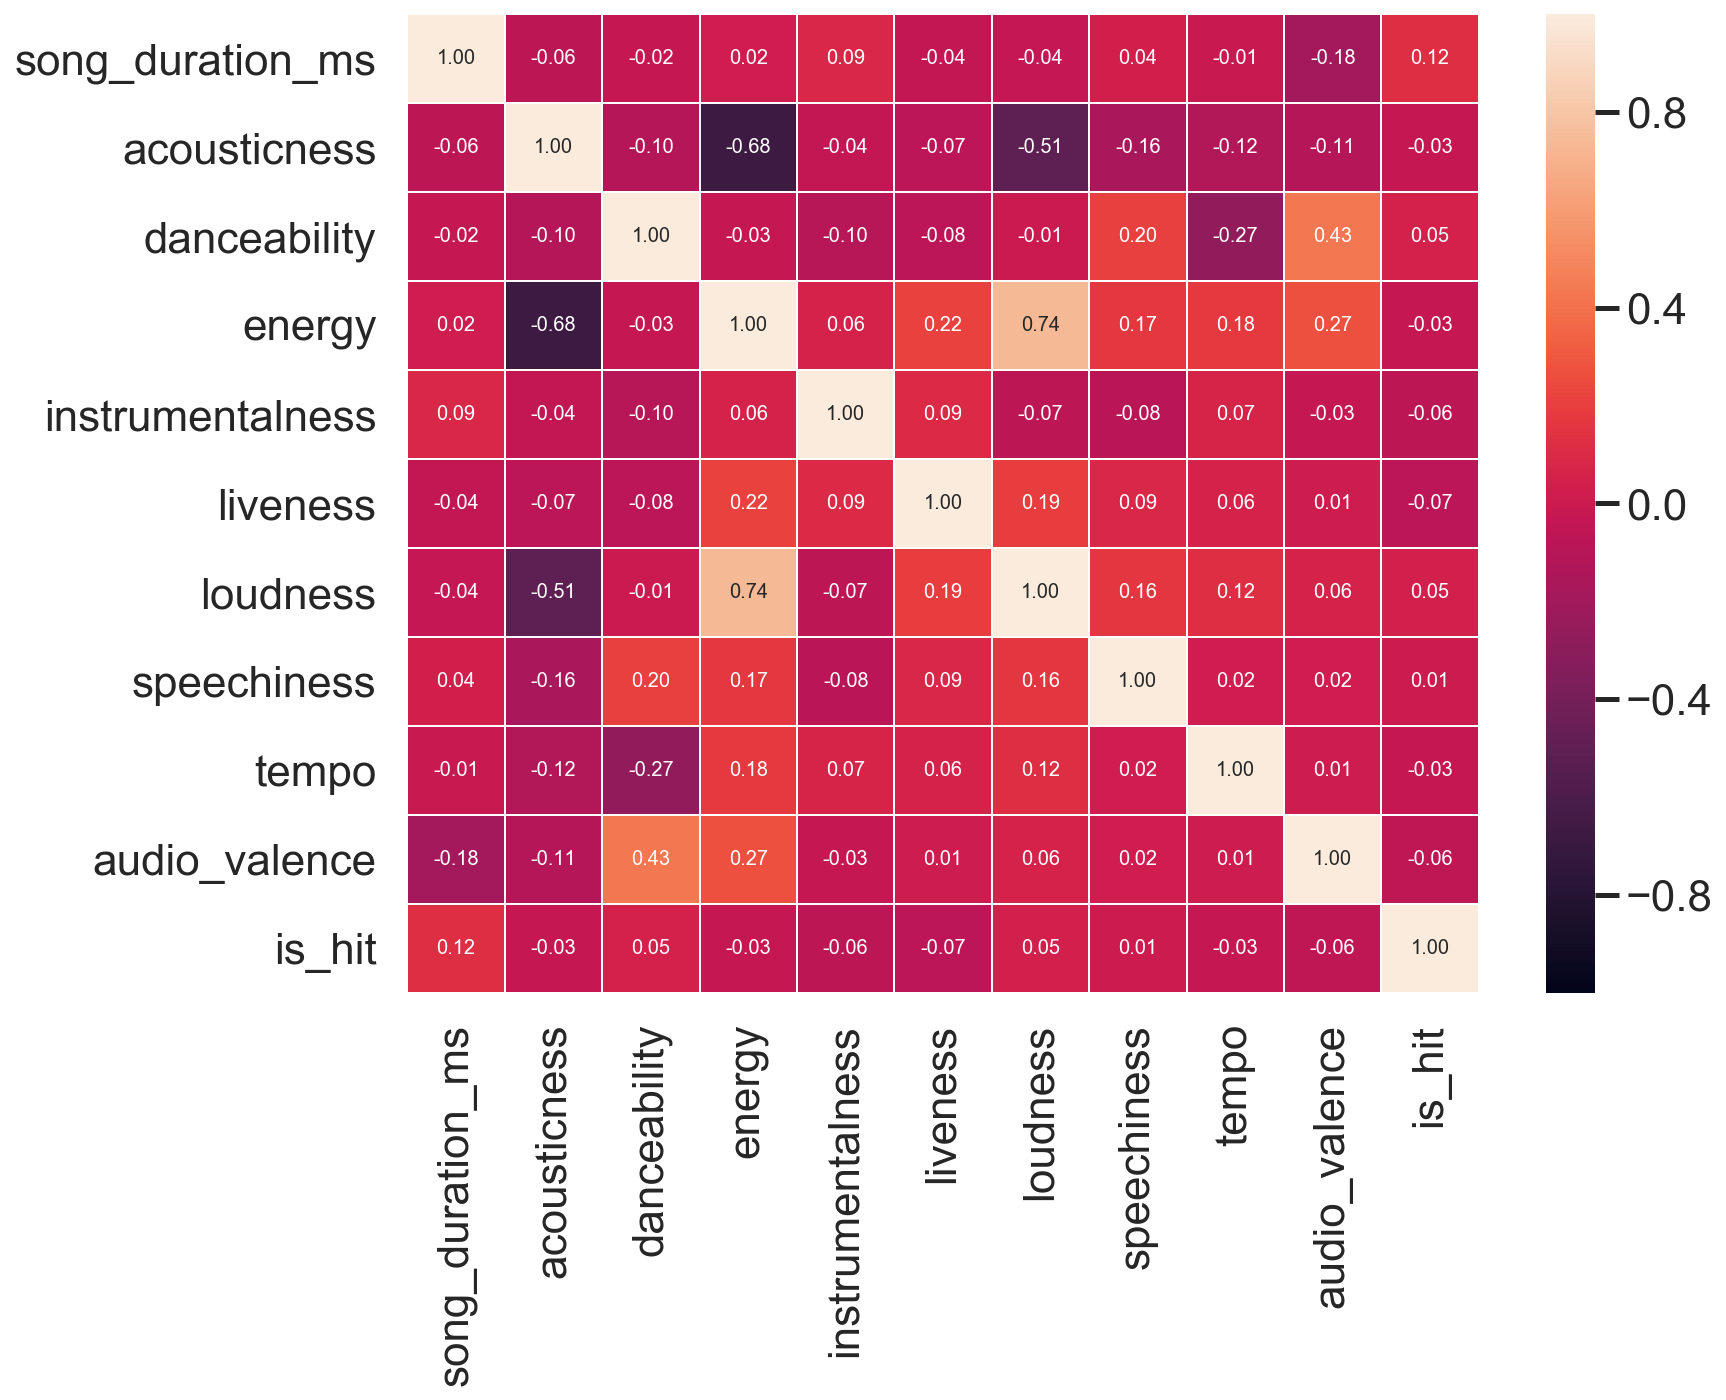

In [11]:
plt.figure(figsize=(12, 9))  
ax=sns.heatmap(
    pd.concat([df[col_quant],df["is_hit"]],axis=1).corr(),
    vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=0.5)
ax.set_ylim(11.0, 0.0)
plt.show()

### plot influenced song name words for target 

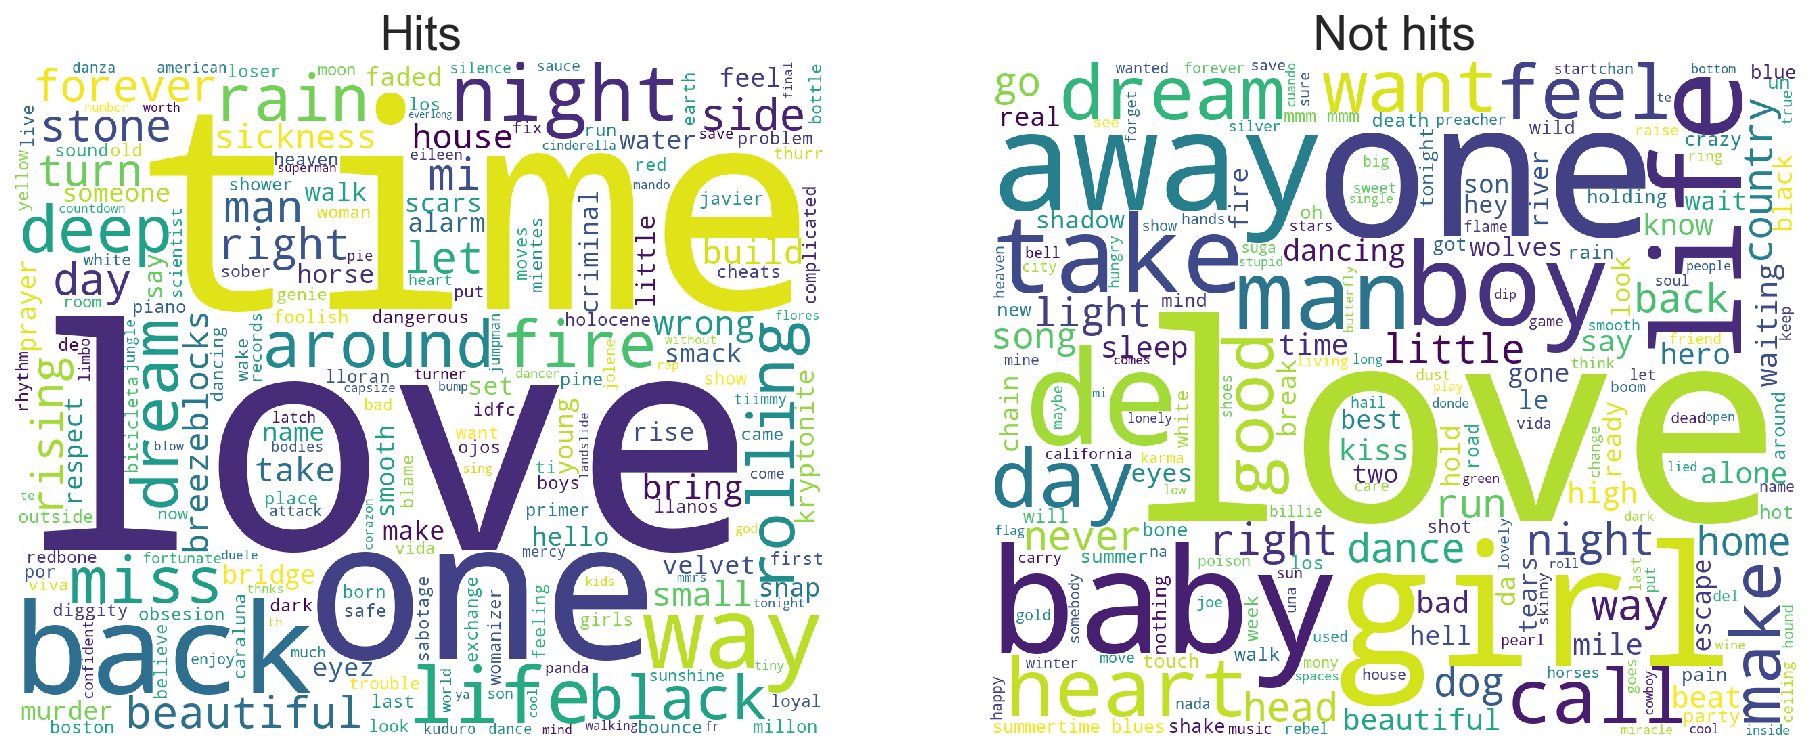

In [12]:
stop_words= ['feat', 'remix', 'remastered', 'version', 'el', 'la', 'lil', 'don', 'radio', 'edit']
def clean_text(series):
    return series.str.replace('[^a-zA-Z]', ' ').replace('\s+', ' ', regex=True).str.strip().str.lower()

def clean_stopwords(series, stop_wrd=stop_words):
    return series.fillna('').apply(
        lambda text: ' '.join([word for word in text.split() if word.lower() not in stop_wrd]))

def plot_wordcloud(text, title):
    wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")

fig, ax = plt.subplots(figsize = (16, 12))
plt.subplot(1, 2, 1)
lst_hit_name = clean_stopwords(clean_text(df.loc[df['is_hit'] == 1, 'song_name']))
str_hit_name = ' '.join(lst_hit_name)
plot_wordcloud(str_hit_name, 'Hits')

plt.subplot(1, 2, 2)
lst_nonhit_name = clean_stopwords(clean_text(df.loc[df['is_hit'] == 0, 'song_name']))
str_nonhit_name = ' '.join(lst_nonhit_name)
plot_wordcloud(str_nonhit_name, 'Not hits')

plt.show()

### Plot lyrics 3d embeddings space

In [13]:
sentences_vec = []
for sent_str in df['lyrics']:
    vec = text_to_vector(dct_fasttext, sent_str)
    sentences_vec.append(vec)
sentences_vec = np.array(sentences_vec)

tsne = TSNE(n_components=3, learning_rate=200, random_state=0, n_iter=3_000)
sentences_tsne = tsne.fit_transform(sentences_vec)

x_coords = sentences_tsne[:, 0]
y_coords = sentences_tsne[:, 1]
z_coords = sentences_tsne[:, 2]

df_tsne = pd.DataFrame({'lyrics_vec_x':x_coords, 'lyrics_vec_y':y_coords, 'lyrics_vec_z':z_coords})

In [14]:
labelEncoder = LabelEncoder()
dct_layout_options = {
        'showbackground':False,
        'zeroline': False,
        'ticks': '',
        'autorange': True,
        'showgrid': False,
        'zeroline': False,
        'ticks': '',
        'showticklabels': False,
        'showspikes':False
    }


plot = [go.Scatter3d(x = x_coords,
                    y = y_coords,
                    z = z_coords,
                    mode = 'markers',
                    text = df['composition'],
                    textposition='bottom center',
                    hoverinfo = 'text',
                    hovertext=df['composition'],
                    textfont={
                        "color": '#BEBEBE',}, 
                     
                    marker=dict(size=5,
                                opacity=0.8,
                           colorscale='geyser',
                                color=labelEncoder.fit_transform(df['is_hit']),))]

layout = go.Layout(scene = dict(
                    bgcolor = 'rgb(20, 24, 54)',
                    xaxis =  dct_layout_options,    
                    yaxis = dct_layout_options,
                    zaxis = dct_layout_options,),
                    width=700,
                    margin=dict(
                        r=10, l=10,
                        b=10, t=10)
                  )
fig = go.Figure(data=plot, layout=layout)

iplot(fig)

# Modelling

In [15]:
col_trainless = ['genre', 'song_name', 'artist_name', 'song_popularity', 'is_hit', 'song', 'year', 'artist', 'lyrics', 'composition']
df = pd.concat([df, df_tsne], axis=1)

df_tr, df_te = train_test_split(df, test_size=0.2, random_state=1)

train_X = df_tr.drop(col_trainless+col_cat, axis=1)
test_X = df_te.drop(col_trainless+col_cat, axis=1)
train_y = df_tr['is_hit']
test_y = df_te['is_hit']
feature_names = train_X.columns

In [16]:
scaler = MinMaxScaler()
train_X_scale = scaler.fit_transform(train_X)
test_X_scale = scaler.transform(test_X) 

In [17]:
model = LogisticRegressionCV(Cs = [10, 1, 0.1, 0.001, 0.0005], max_iter=300, class_weight='balanced').fit(train_X_scale, train_y)

# evaluating the results

In [18]:
se_pred = pd.Series(model.predict_proba(test_X_scale)[:,1], name='proba')

print(f'roc_auc_score: {roc_auc_score(test_y, se_pred)}')

roc_auc_score: 0.7065404475043029


In [19]:
top_n = 3
coef = pd.Series(model.coef_[0], index = feature_names)
imp_coef = pd.concat([coef.sort_values().head(top_n),
                     coef.sort_values().tail(top_n)])

### plot model important feature

Text(0.5, 1.0, 'Coefficients in the LogisticRegression')

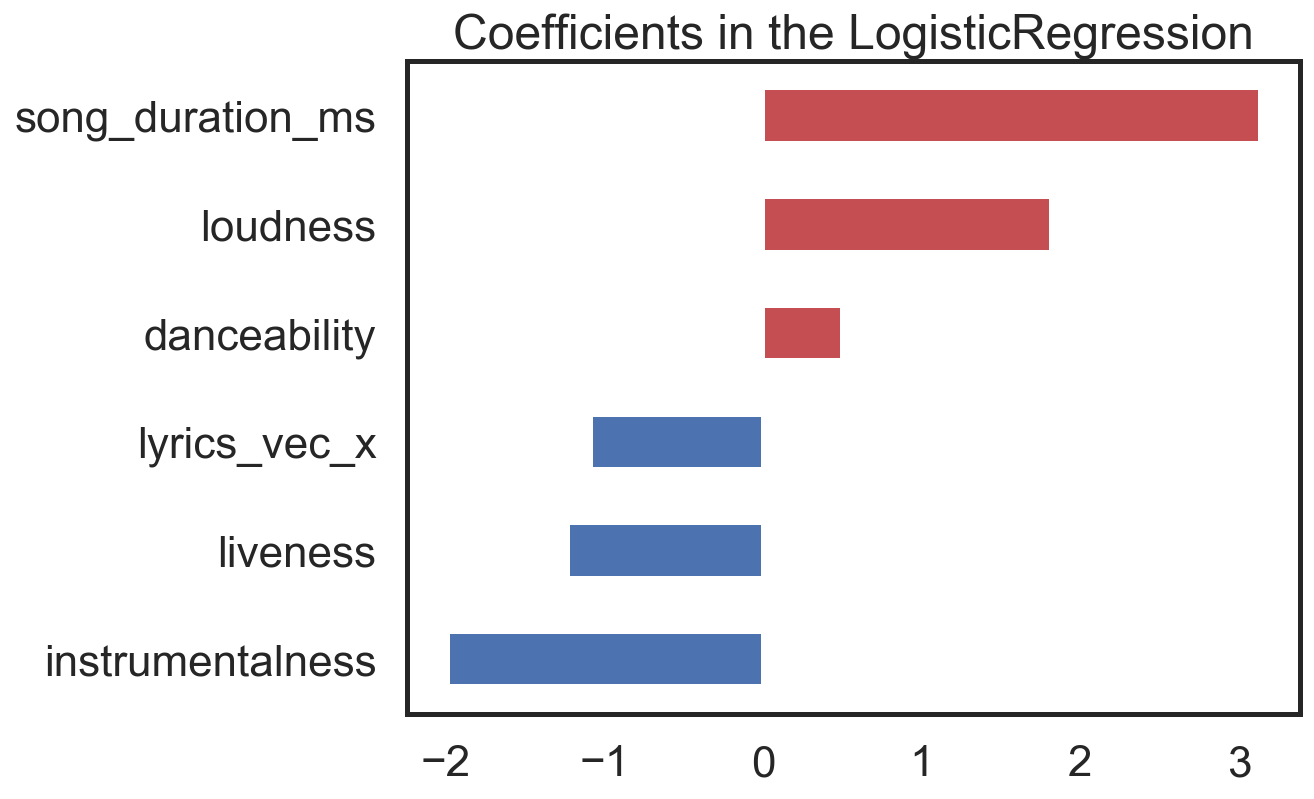

In [20]:
plt.rcParams['figure.figsize'] = (8, 6)
imp_coef.plot(kind = "barh", color=(imp_coef>0).map({True:'r', False:'b'}).values)
plt.title("Coefficients in the LogisticRegression")